In [106]:
import numpy as np
import pandas as pd
import numba
from numba import njit, prange
from sklearn import neighbors
import itertools
from itertools import product

In [2]:
df6 = pd.read_csv('df6_small.csv', index_col ='date')
comb_list = np.load('comb_list_small.npy').tolist()

In [107]:
def pct_chg(arr):
    eps = 1e-6
    next_values = arr[:, :, 1::]
    prev_values = arr[:, :, 0:-1]
    prev_values[prev_values == 0] = eps
    chg = next_values / prev_values - 1
    return chg

def pattern_sig(arr, thr):
    arr[arr > thr ] = 1
    arr[arr < -thr ] = -1
    arr[(arr >= -thr ) & (arr <= thr)] = 0
    return arr.astype(int)

def to_str(arr):
    arr_ = arr.reshape(arr.shape[0], arr.shape[2]*2)
    arr__ = arr_.astype(str).tolist()
    arr_str = [",".join(string) for string in arr__]
    return arr_str

def exp_weight(X):
    norm = X[:,[0]] +.00001
    numer = np.exp(-X/norm)
    denom = np.sum(numer,axis=1,keepdims=True)
    W = numer/denom
    return W  

def PC_metrics(pred, actual):
    l, k = pred.shape
    x_stack_str = to_str(np.stack((pred, actual), 1).astype(np.int8))
    
    patterns = np.array(list(product(np.arange(-1, 2, 1), repeat=k)), dtype=np.int8)
    patterns_product = np.array(list(product(patterns, repeat=2)), dtype=np.int8)
    patterns_product_str = np.array(to_str(patterns_product))[:, np.newaxis]
    
    m = int(patterns_product.shape[0]**(1/2))
    indices = np.array([[i,j] for i in range(m) for j in range(m)])
    pattern_grid = np.hstack((patterns_product_str, indices))
    
    x_unique = np.unique(x_stack_str, return_counts = True)
    x_unique_df = pd.DataFrame(x_unique[1], index = x_unique[0], columns = ['counts'])
    pattern_grid_df = pd.DataFrame(pattern_grid[:,1:], index = pattern_grid[:,0], columns=['x', 'y'])
    total_counts = pattern_grid_df.join(x_unique_df)
    total_counts.fillna(0, inplace=True)
    total_counts_arr = total_counts.to_numpy().astype(int)
    
    confusion_matrix = np.zeros((m, m))
    for pat in total_counts_arr:
        confusion_matrix[pat[0], pat[1]] = pat[2]
    confusion_matrix /= l
        
    PC_pos = np.trace(confusion_matrix)
    PC_neg = np.trace(np.fliplr(confusion_matrix))
    if (m % 2) == 0:
        PC_dark = 1 - (PC_pos + PC_neg)
    else:
        PC_dark = 1 - (PC_pos + PC_neg) + np.median(np.diag(confusion_matrix))
            
    return PC_pos, PC_neg, PC_dark

@njit(parallel=True)
def numba_embed_vectors_1d(X, lag, embed):
        tsize = X.shape[0]
        t_iter = tsize-(lag*(embed-1))
        features = np.zeros((t_iter,embed))
        for ii in prange(t_iter):
            end_val = ii+lag*(embed-1)+1
            part = X[ii : end_val]
            features[ii,:] = part[::lag]
        return features

In [108]:
class PatternCausality:

    def __init__(self, weights='exp', verbose=False):
        self.weights = weights
        self.verbose = verbose    
    
    def fit(self, X1, X2, x1, x2):

        self.X1 = X1
        self.X2 = X2
        self.x1 = x1
        self.x2 = x2

        near_neighs = X1.shape[1] + 2

        self.knn1 = neighbors.KNeighborsRegressor(near_neighs, p = 2) #, weights='distance', algorithm='kd_tree'
        self.knn2 = neighbors.KNeighborsRegressor(near_neighs, p = 2) #, weights='distance', algorithm='kd_tree',

    def predict_stocks(self, lib_lengths, thr_rate, lag):

        X1_pred = []
        X2_pred = []
        
        X01_pred = []
        X02_pred = []
        
        eps =0.0001
        
        for liblen in lib_lengths:
            
            self.x1[:liblen][self.x1[:liblen]==0]=eps
            self.x2[:liblen][self.x2[:liblen]==0]=eps
            
            x1_ret = np.log(self.x1[:liblen] / self.x1[:liblen].shift(lag)).dropna().values
            x2_ret = np.log(self.x2[:liblen] / self.x2[:liblen].shift(lag)).dropna().values
            
            thr1 = thr_rate * np.std(x1_ret)
            thr2 = thr_rate * np.std(x2_ret)
            
            Signatures1 = np.empty((liblen, self.X1.shape[1] + 1, self.X1.shape[1] - 1))
            Signatures2 = np.empty((liblen, self.X1.shape[1] + 1, self.X1.shape[1] - 1))
            
            Signatures01 = np.empty((liblen, self.X1.shape[1] + 1, self.X1.shape[1] - 1))
            Signatures02 = np.empty((liblen, self.X1.shape[1] + 1, self.X1.shape[1] - 1))

            #keep only the indices that are less than library length
            self.knn1.fit(self.X1[:liblen], self.X1[:liblen])
            self.knn2.fit(self.X2[:liblen], self.X2[:liblen])

            dist1,ind1 = self.knn1.kneighbors(self.X1[:liblen])
            dist2,ind2 = self.knn2.kneighbors(self.X2[:liblen])

            #drop indices and distances to themselves
            dist1 = dist1[:,1:]
            dist2 = dist2[:,1:]
            ind1 = ind1[:,1:]
            ind2 = ind2[:,1:]
            
            X1_ind2 = self.X1[ind2]
            X2_ind1 = self.X2[ind1]
            
            X1_ind1 = self.X1[ind1]
            X2_ind2 = self.X2[ind2]
            
            S1 = pct_chg(X1_ind2)
            S2 = pct_chg(X2_ind1)
            
            S01 = pct_chg(X1_ind1)
            S02 = pct_chg(X2_ind2)
            
            for j in range(self.X1.shape[1] + 1):

                W1 = exp_weight(dist1)
                W2 = exp_weight(dist2)
                
                #cross
                Signatures1[:, j] = S1[:, j] * W2[:, [j]]
                Signatures2[:, j] = S2[:, j] * W1[:, [j]]
    
                #original
                Signatures01[:, j] = S01[:, j] * W1[:, [j]]
                Signatures02[:, j] = S02[:, j] * W2[:, [j]]
                
            x1_p = pattern_sig(np.sum(Signatures1, axis=1), thr1)
            x2_p = pattern_sig(np.sum(Signatures2, axis=1), thr2)

            x01_p = pattern_sig(np.sum(Signatures01, axis=1), thr1)
            x02_p = pattern_sig(np.sum(Signatures02, axis=1), thr2)

            X1_pred.append(x1_p)
            X2_pred.append(x2_p)
            
            X01_pred.append(x01_p)
            X02_pred.append(x02_p)
            
        self.X1_pred = X1_pred
        self.X2_pred = X2_pred
        
        self.X01_pred = X01_pred
        self.X02_pred = X02_pred

        return X1_pred, X2_pred, X01_pred, X02_pred
    
    def PC_score(self):
        
        score_1 = []
        score_2 = []

        for x1_p, x2_p, x01_p, x02_p in zip(self.X1_pred, self.X2_pred, self.X01_pred, self.X02_pred):

            PC_pos_xy, PC_neg_xy, PC_dark_xy = PC_metrics(x1_p, x01_p)
            PC_pos_yx, PC_neg_yx, PC_dark_yx = PC_metrics(x2_p, x02_p)

            score_1.append([PC_pos_xy, PC_neg_xy, PC_dark_xy])
            score_2.append([PC_pos_yx, PC_neg_yx, PC_dark_yx])

        return np.array(score_1), np.array(score_2)

In [9]:
def pcs(comb_list, df6):
    pc_scores_mean = []
    pc_scores_max = []
    for i in range(len(comb_list)):
        tickers = comb_list[i]
        
        x1_ = df6[tickers[0]]
        x2_ = df6[tickers[1]]
        
        x1 = df6[tickers[0]].to_numpy()
        x2 = df6[tickers[1]].to_numpy()

        lag = 1
        embed = 3
        X1 = numba_embed_vectors_1d(x1, lag, embed)
        X2 = numba_embed_vectors_1d(x2, lag, embed)
        lib_lens = np.array([125, 250, 500, 750, 1000, len(X1)], dtype='int')

        PC = PatternCausality()
        PC.fit(X1, X2, x1_, x2_)
        X1_pred, X2_pred, X01_pred, X02_pred = PC.predict_stocks(lib_lengths=lib_lens, thr_rate=0.001, lag=lag)

        sc1, sc2 = PC.PC_score()
        PC_pos_xy, PC_neg_xy, PC_dark_xy = sc1[:,0], sc1[:,1], sc1[:,2]
        PC_pos_yx, PC_neg_yx, PC_dark_yx = sc2[:,0], sc2[:,1], sc2[:,2]

        pc_scores_mean.append([np.mean(PC_pos_xy), np.mean(PC_pos_yx)])
        pc_scores_max.append([np.max(PC_pos_xy), np.max(PC_pos_yx)])
        
    return pc_scores_mean, pc_scores_max

In [ ]:
pc_scores_mean, pc_scores_max = pcs(comb_list, df6)

In [13]:
np.save('pc_scores_mean_small.npy', pc_scores_mean)
np.save('pc_scores_max_small.npy', pc_scores_max)

In [2]:
pc_max_small = np.load('pc_scores_max_small.npy')
pc_max_mid = np.load('pc_scores_max_mid.npy')
pc_max_large = np.load('pc_scores_max_large.npy')

pc_mean_small = np.load('pc_scores_mean_small.npy')
pc_mean_mid = np.load('pc_scores_mean_mid.npy')
pc_mean_large = np.load('pc_scores_mean_large.npy')

In [3]:
pc_max_tot = np.vstack((pc_max_small, pc_max_mid, pc_max_large))
pc_max_tot

array([[0.416     , 0.364     ],
       [0.33412888, 0.316     ],
       [0.32      , 0.346     ],
       ...,
       [0.346     , 0.376     ],
       [0.3468576 , 0.356     ],
       [0.352     , 0.35719968]])

In [4]:
pc_mean_tot = np.vstack((pc_mean_small, pc_mean_mid, pc_mean_large))
pc_mean_tot

array([[0.3390838 , 0.32679196],
       [0.32363259, 0.30090453],
       [0.3051371 , 0.32102745],
       ...,
       [0.31716521, 0.33801114],
       [0.30658738, 0.32641037],
       [0.31712371, 0.33531106]])

In [6]:
pc_max_tot.shape

(1142484, 2)

In [7]:
#np.save('pc_max_tot.npy', pc_max_tot)
#np.save('pc_mean_tot.npy', pc_mean_tot)

In [18]:
comb_list_small = np.load('comb_list_small.npy')
comb_list_mid = np.load('comb_list_mid.npy')
comb_list_large = np.load('comb_list_large.npy')

In [19]:
comb_list_tot = np.vstack((comb_list_small, comb_list_mid, comb_list_large))

In [21]:
comb_list_tot

array([['AAIC', 'AAMC'],
       ['AAIC', 'AAON'],
       ['AAIC', 'AAT'],
       ...,
       ['YUM', 'ZBH'],
       ['YUM', 'ZTS'],
       ['ZBH', 'ZTS']], dtype='<U5')

In [72]:
adf_stats_tot = np.load('adf_stats_tot.npy').astype(int)
gc_stats_tot = np.load('gc_stats_tot.npy').astype(int)

ccm_max_tot = np.round(np.load('ccm_max_tot.npy'), 4)
ccm_mean_tot = np.round(np.load('ccm_mean_tot.npy'), 4)

pc_max_tot = np.round(np.load('pc_max_tot.npy'), 4)
pc_mean_tot = np.round(np.load('pc_mean_tot.npy'), 4)

In [49]:
ccm_max_tot.shape

(1142484, 2)

In [73]:
tot_stats = np.hstack((comb_list_tot, adf_stats_tot, gc_stats_tot, ccm_max_tot, ccm_mean_tot, pc_max_tot, pc_mean_tot))

In [74]:
agg_df = pd.DataFrame(tot_stats, columns=['ticker_x', 'ticker_y', 'coint_df_n', 'coint_df_c', 'coint_df_ct', 'gc_x', 'gc_y', 
                                 'ccm_max_x', 'ccm_max_y', 'ccm_mean_x', 'ccm_mean_y',
                                 'pc_max_x', 'pc_max_y', 'pc_mean_x', 'pc_mean_y'])
agg_df['coint_df_n'] = agg_df['coint_df_n'].astype(int)
agg_df['coint_df_c'] = agg_df['coint_df_c'].astype(int)
agg_df['coint_df_ct'] = agg_df['coint_df_ct'].astype(int)
agg_df['gc_x'] = agg_df['gc_x'].astype(int)
agg_df['gc_y'] = agg_df['gc_y'].astype(int)
agg_df

,ticker_x,ticker_y,coint_df_n,coint_df_c,coint_df_ct,gc_x,gc_y,ccm_max_x,ccm_max_y,ccm_mean_x,ccm_mean_y,pc_max_x,pc_max_y,pc_mean_x,pc_mean_y
0,AAIC,AAMC,0,0,0,0,0,0.0598,0.103,0.0482,0.0734,0.416,0.364,0.3391,0.3268
1,AAIC,AAON,1,0,0,0,0,0.1411,0.1708,0.1345,0.1592,0.3341,0.316,0.3236,0.3009
2,AAIC,AAT,1,1,0,0,0,0.1772,0.2535,0.1521,0.2162,0.32,0.346,0.3051,0.321
3,AAIC,AB,1,0,0,0,0,0.1928,0.2365,0.1585,0.1942,0.3493,0.336,0.3115,0.3109
4,AAIC,ABEO,1,0,0,0,0,0.0511,0.0465,0.0313,0.0211,0.322,0.2689,0.3049,0.2296
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1142479,YELP,ZBH,1,1,0,1,0,0.1164,0.144,0.1052,0.1269,0.376,0.3053,0.3119,0.2889
1142480,YELP,ZTS,0,0,0,0,0,0.0846,0.132,0.0665,0.0842,0.344,0.346,0.3093,0.3268
1142481,YUM,ZBH,1,0,0,1,0,0.1745,0.2352,0.1341,0.2013,0.346,0.376,0.3172,0.338
1142482,YUM,ZTS,0,0,0,1,0,0.132,0.1902,0.1181,0.1615,0.3469,0.356,0.3066,0.3264


In [75]:
all_liquid_equities = np.unique(comb_list_tot)
all_liquid_equities.shape

(2482,)

In [76]:
agg_df

,ticker_x,ticker_y,coint_df_n,coint_df_c,coint_df_ct,gc_x,gc_y,ccm_max_x,ccm_max_y,ccm_mean_x,ccm_mean_y,pc_max_x,pc_max_y,pc_mean_x,pc_mean_y
0,AAIC,AAMC,0,0,0,0,0,0.0598,0.103,0.0482,0.0734,0.416,0.364,0.3391,0.3268
1,AAIC,AAON,1,0,0,0,0,0.1411,0.1708,0.1345,0.1592,0.3341,0.316,0.3236,0.3009
2,AAIC,AAT,1,1,0,0,0,0.1772,0.2535,0.1521,0.2162,0.32,0.346,0.3051,0.321
3,AAIC,AB,1,0,0,0,0,0.1928,0.2365,0.1585,0.1942,0.3493,0.336,0.3115,0.3109
4,AAIC,ABEO,1,0,0,0,0,0.0511,0.0465,0.0313,0.0211,0.322,0.2689,0.3049,0.2296
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1142479,YELP,ZBH,1,1,0,1,0,0.1164,0.144,0.1052,0.1269,0.376,0.3053,0.3119,0.2889
1142480,YELP,ZTS,0,0,0,0,0,0.0846,0.132,0.0665,0.0842,0.344,0.346,0.3093,0.3268
1142481,YUM,ZBH,1,0,0,1,0,0.1745,0.2352,0.1341,0.2013,0.346,0.376,0.3172,0.338
1142482,YUM,ZTS,0,0,0,1,0,0.132,0.1902,0.1181,0.1615,0.3469,0.356,0.3066,0.3264


In [89]:
df0 = agg_df[(agg_df.coint_df_n==1) | (agg_df.coint_df_c==1) | (agg_df.coint_df_ct==1)].sort_values(by=['pc_max_x', 'pc_max_y'], ascending=[False, False])[:10]
df0

,ticker_x,ticker_y,coint_df_n,coint_df_c,coint_df_ct,gc_x,gc_y,ccm_max_x,ccm_max_y,ccm_mean_x,ccm_mean_y,pc_max_x,pc_max_y,pc_mean_x,pc_mean_y
969086,NWS,NWSA,1,1,1,0,0,0.9319,0.9326,0.9081,0.9041,0.736,0.74,0.7084,0.6999
168021,CENT,CENTA,1,1,0,1,0,0.927,0.928,0.9017,0.9074,0.692,0.6993,0.6594,0.6675
1067569,BBD,ITUB,1,0,0,0,0,0.8199,0.7782,0.8083,0.747,0.69,0.69,0.6338,0.6208
539242,AMKR,PSXP,1,1,1,0,0,0.0741,0.1291,0.045,0.054,0.68,0.44,0.3836,0.305
560526,ARW,AVT,1,1,1,0,0,0.744,0.7392,0.7298,0.7236,0.666,0.638,0.6113,0.5882
680179,CM,RY,1,0,1,1,1,0.7547,0.7542,0.7201,0.7209,0.664,0.5537,0.5692,0.5303
283725,FCF,IBOC,1,1,1,1,1,0.7467,0.782,0.7347,0.7738,0.656,0.688,0.5856,0.5973
284145,FCF,TRMK,1,1,1,1,1,0.7799,0.8093,0.7554,0.7924,0.656,0.6307,0.6164,0.6058
1120018,KEY,RF,1,0,0,0,0,0.829,0.8169,0.8089,0.8058,0.6547,0.648,0.6224,0.6274
538857,AMKR,FUL,1,1,1,0,0,0.2269,0.262,0.2018,0.2431,0.648,0.36,0.4212,0.3439


In [88]:
df1 = agg_df[(agg_df.coint_df_n==0) & (agg_df.coint_df_c==0) & (agg_df.coint_df_ct==0)].sort_values(by=['pc_max_x', 'pc_max_y'], ascending=[False, False])[:10]
df1

,ticker_x,ticker_y,coint_df_n,coint_df_c,coint_df_ct,gc_x,gc_y,ccm_max_x,ccm_max_y,ccm_mean_x,ccm_mean_y,pc_max_x,pc_max_y,pc_mean_x,pc_mean_y
1136303,PNC,STT,0,0,0,0,0,0.6421,0.5908,0.6047,0.5721,0.696,0.54,0.5324,0.5051
618207,BMA,GGAL,0,0,0,1,0,0.7423,0.7413,0.7294,0.733,0.664,0.608,0.558,0.5257
539233,AMKR,PRG,0,0,0,0,0,0.0747,0.0859,0.0542,0.0617,0.656,0.384,0.3758,0.3092
1127074,MGM,WYNN,0,0,0,0,0,0.5959,0.5653,0.5526,0.5444,0.648,0.672,0.5374,0.534
538782,AMKR,EBIX,0,0,0,0,0,0.1419,0.1564,0.1145,0.1323,0.648,0.368,0.3792,0.3229
796413,FMBI,GBCI,0,0,0,0,0,0.7994,0.8046,0.7762,0.7836,0.6453,0.6453,0.603,0.5828
1126800,MET,PRU,0,0,0,1,1,0.8028,0.8246,0.7889,0.8105,0.642,0.658,0.5823,0.598
538657,AMKR,CBRE,0,0,0,0,1,0.1864,0.2507,0.1731,0.2419,0.64,0.376,0.4046,0.3212
689964,COLB,GBCI,0,0,0,1,1,0.8057,0.8029,0.7868,0.7889,0.6373,0.588,0.5845,0.5541
650884,CBU,FMBI,0,0,0,0,0,0.7713,0.7685,0.7567,0.7521,0.636,0.608,0.5814,0.5585


In [87]:
df2 = agg_df[(agg_df.coint_df_n==0) & (agg_df.coint_df_c==0) & (agg_df.coint_df_ct==0)].sort_values(by=['ccm_max_x', 'ccm_max_y', 'pc_max_x', 'pc_max_y'], ascending=[True, True, False, False])[:10]
df2

,ticker_x,ticker_y,coint_df_n,coint_df_c,coint_df_ct,gc_x,gc_y,ccm_max_x,ccm_max_y,ccm_mean_x,ccm_mean_y,pc_max_x,pc_max_y,pc_mean_x,pc_mean_y
173174,CGEN,MUX,0,0,0,0,0,-0.0,-0.0023,-0.0095,-0.0142,0.292,0.2506,0.2706,0.2315
322995,GRVY,SMLP,0,0,0,0,0,-0.0,-0.0046,-0.0127,-0.0289,0.264,0.272,0.2408,0.2495
156935,CBLI,EBR,0,0,0,0,0,-0.0,-0.0058,-0.0248,-0.01,0.336,0.268,0.28,0.2576
65563,AQN,BSQR,0,0,0,0,0,-0.0,-0.0081,-0.0063,-0.0243,0.296,0.272,0.2797,0.2439
510023,AG,CASY,0,0,0,0,0,-0.0,-0.0114,-0.0081,-0.0292,0.32,0.304,0.2596,0.2783
166004,CEI,MBWM,0,0,0,0,0,-0.0,-0.0166,-0.0035,-0.0262,0.2657,0.29,0.2518,0.2745
504109,AEM,ISEE,0,0,0,0,0,-0.0,0.0001,-0.0108,-0.0143,0.296,0.248,0.2291,0.2207
169307,CENTA,OTRK,0,0,0,0,1,-0.0,0.0059,-0.0132,-0.0144,0.344,0.242,0.3008,0.2071
166904,CELH,OEG,0,0,0,0,0,-0.0,0.0063,-0.0407,-0.0142,0.272,0.344,0.2626,0.2891
357246,IMMP,SYPR,0,0,0,0,0,-0.0,0.0083,-0.0081,0.0004,0.28,0.284,0.2596,0.2677


In [98]:
df5_small = pd.read_csv('df5_small.csv', index_col ='date')
df6_small = pd.read_csv('df6_small.csv', index_col ='date')

df5_mid = pd.read_csv('df5_mid.csv', index_col ='date')
df6_mid = pd.read_csv('df6_mid.csv', index_col ='date')

df5_large = pd.read_csv('df5_large.csv', index_col ='date')
df6_large = pd.read_csv('df6_large.csv', index_col ='date')

In [99]:
df5_tot = pd.concat([df5_small, df5_mid, df5_large], axis=1)
df6_tot = pd.concat([df6_small, df6_mid, df6_large], axis=1)

In [92]:
list0 = df0.iloc[:,:2].to_numpy()
list1 = df1.iloc[:,:2].to_numpy()
list2 = df2.iloc[:,:2].to_numpy()

In [118]:
def plot_ccm(tickers, df5):
    x1_ = df5[tickers[0]].to_numpy()
    x2_ = df5[tickers[1]].to_numpy()

    lag = 1
    embed = 3
    X1 = numba_embed_vectors_1d(x1_, lag, embed)
    X2 = numba_embed_vectors_1d(x2_, lag, embed)
    len_X1 = len(X1)
    lib_lens = np.linspace(10, len_X1, num=50, dtype='int')
    
    CCM = C_C_M()
    CCM.fit(X1,X2)
    x1p, x2p = CCM.predict(lib_lens)
    sc1, sc2 = CCM.ccm_score()
    
    #plt.figure()
    plt.plot(lib_lens, sc1, color='b', label = str(tickers[0]))
    plt.plot(lib_lens, sc2, color='g', label = str(tickers[1]))
    plt.ylabel('forecast skill')
    plt.xlabel('lib length')
    plt.title('Convergent cross mapping ' + str(tickers[0]) + ' and ' +  str(tickers[1]))
    plt.legend()
    #plt.show()

In [120]:
def plot_pc(tickers, df6): 
    x1_ = df6[tickers[0]]
    x2_ = df6[tickers[1]]

    x1 = df6[tickers[0]].to_numpy()
    x2 = df6[tickers[1]].to_numpy()

    lag = 1
    embed = 3
    X1 = numba_embed_vectors_1d(x1,lag,embed)
    X2 = numba_embed_vectors_1d(x2,lag,embed)

    len_ts = len(X1)
    lib_lens = np.arange(10, len_ts, len_ts/50, dtype='int')

    PC = PatternCausality()
    PC.fit(X1, X2, x1_, x2_)
    X1_pred, X2_pred, X01_pred, X02_pred = PC.predict_stocks(lib_lengths=lib_lens, thr_rate=0.0001, lag=lag)

    sc1, sc2 = PC.PC_score()
    PC_pos_xy, PC_neg_xy, PC_dark_xy = sc1[:,0], sc1[:,1], sc1[:,2]
    PC_pos_yx, PC_neg_yx, PC_dark_yx = sc2[:,0], sc2[:,1], sc2[:,2]

    #plt.figure()
    plt.plot(lib_lens, PC_pos_xy, color='royalblue', label = 'PC_pos_xy')
    plt.plot(lib_lens, PC_neg_xy, color='orange', label = 'PC_neg_xy')
    plt.plot(lib_lens, PC_dark_xy, color='violet', label = 'PC_dark_xy')

    plt.plot(lib_lens, PC_pos_yx, color='blue', label = 'PC_pos_yx')
    plt.plot(lib_lens, PC_neg_yx, color='orangered', label = 'PC_neg_yx')
    plt.plot(lib_lens, PC_dark_yx, color='darkviolet', label = 'PC_dark_yx')

    plt.ylabel('forecast skill')
    plt.xlabel('lib length')
    plt.title('Pattern Causality ' + str(tickers[0]) + ' and ' +  str(tickers[1]))
    plt.legend()
    #plt.show()

In [124]:
import matplotlib.pyplot as plt
def plot_ccm_pc(list_of_tickers):
    for i in range(len(list_of_tickers)):
        plt.figure(figsize=(12,5))
        plt.subplot(1, 2, 1)
        plot_ccm(list_of_tickers[i], df5_tot)
        plt.subplot(1, 2, 2)
        plot_pc(list_of_tickers[i], df6_tot)
        plt.show()

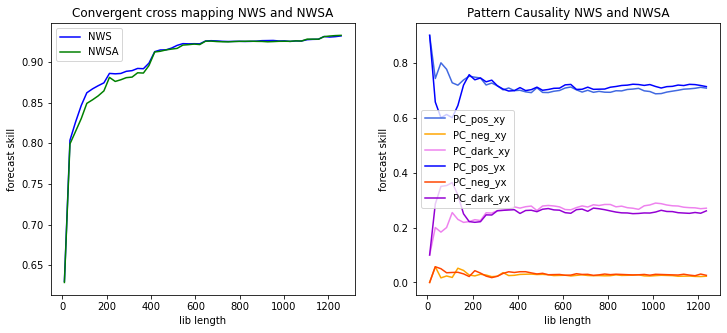

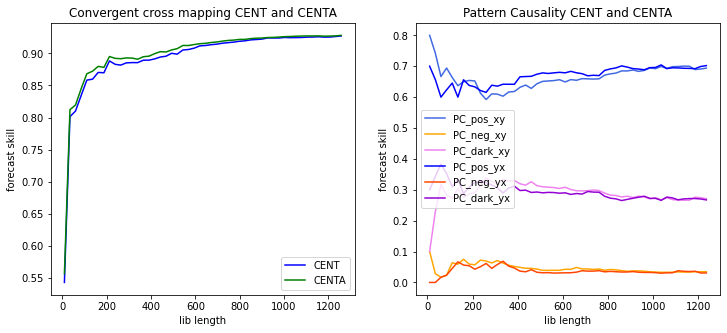

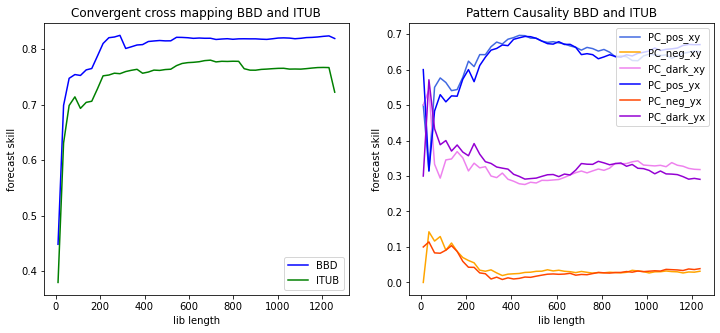

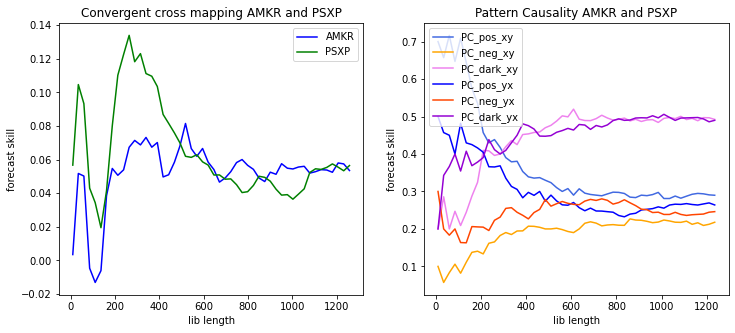

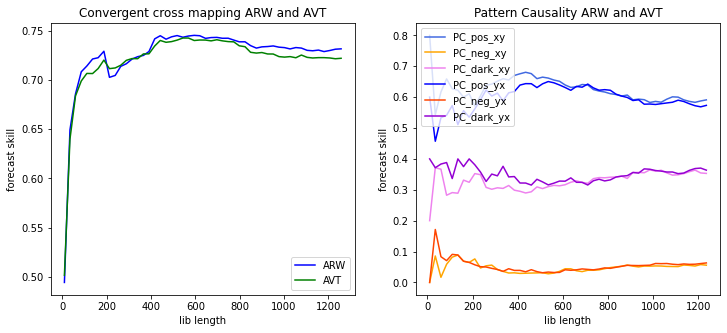

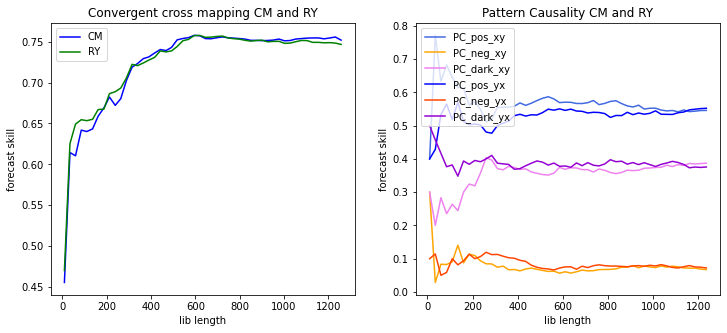

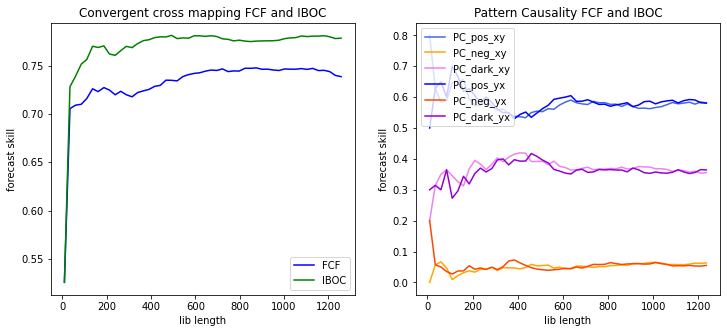

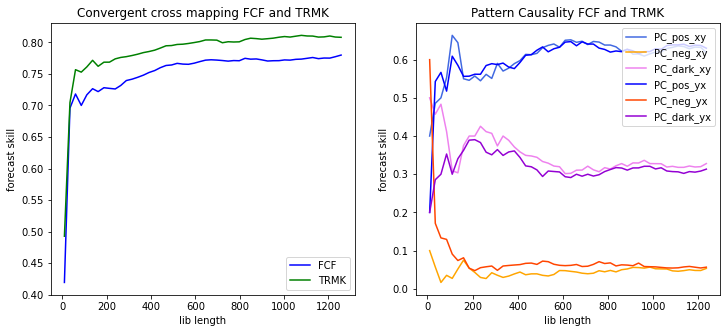

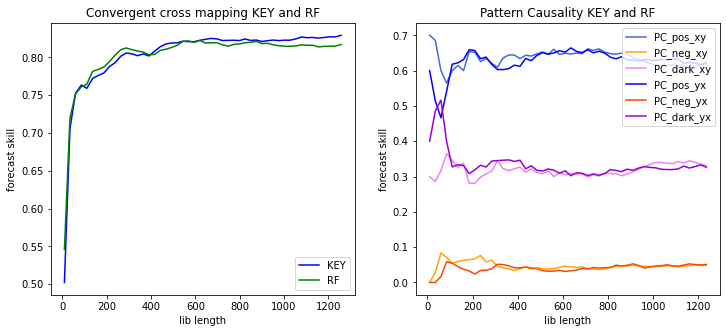

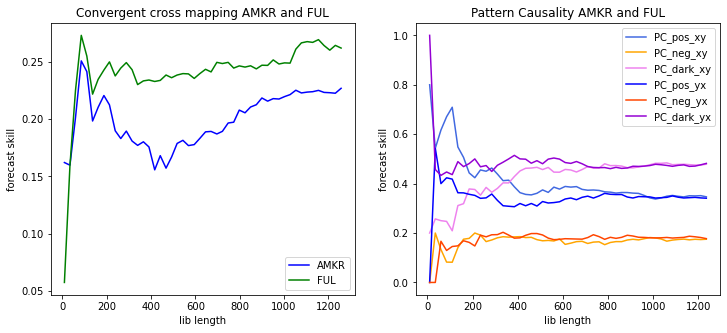

In [125]:
plot_ccm_pc(list0)

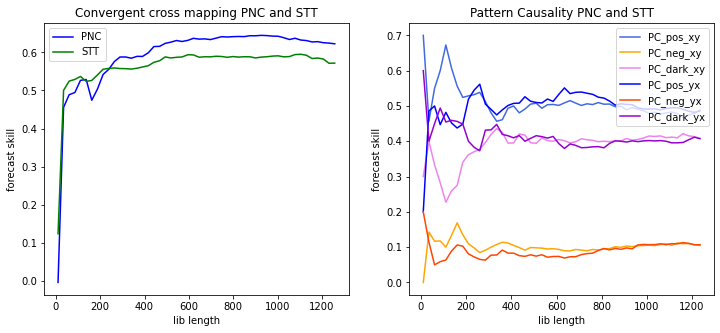

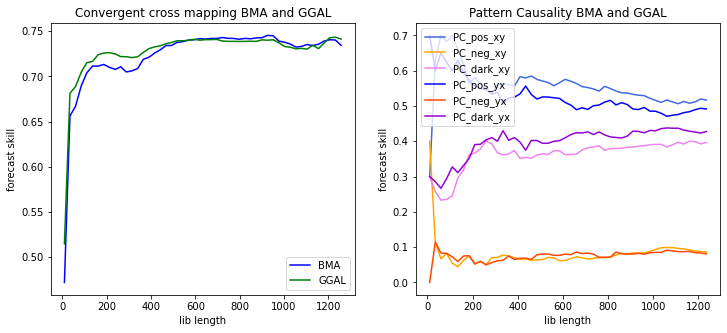

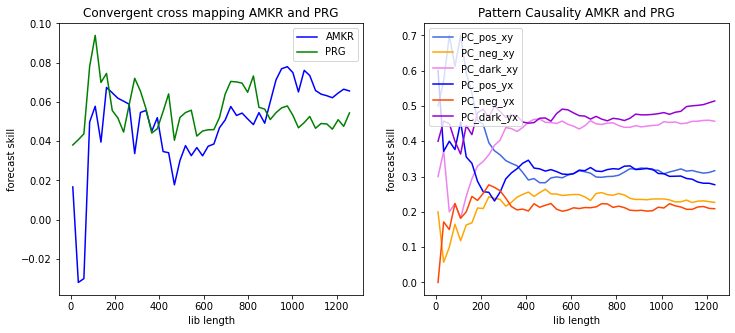

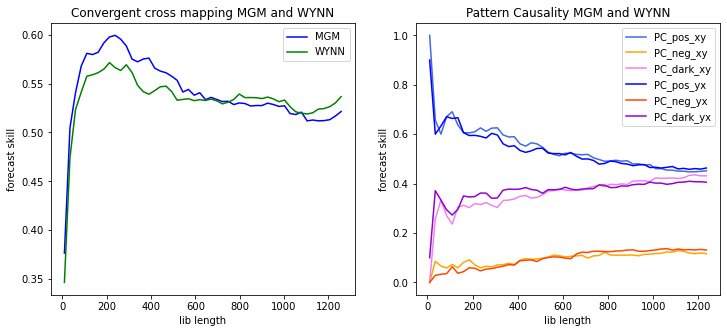

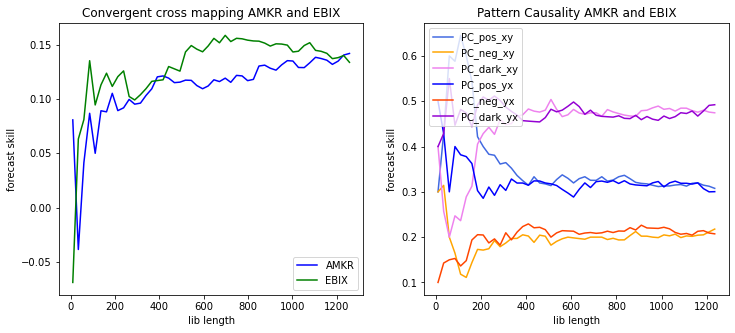

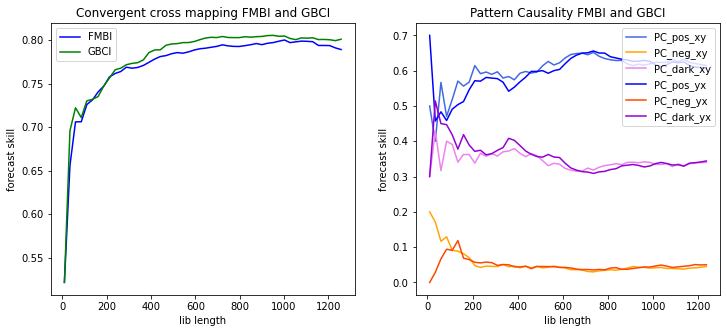

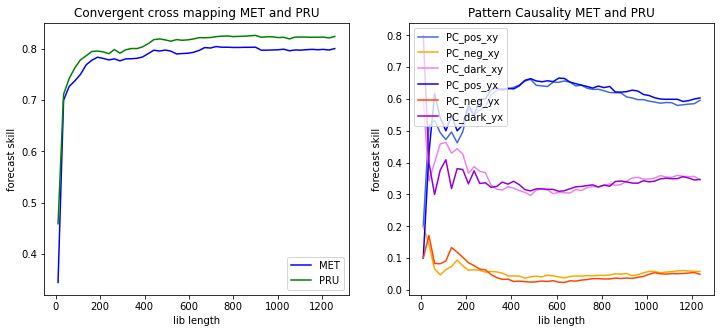

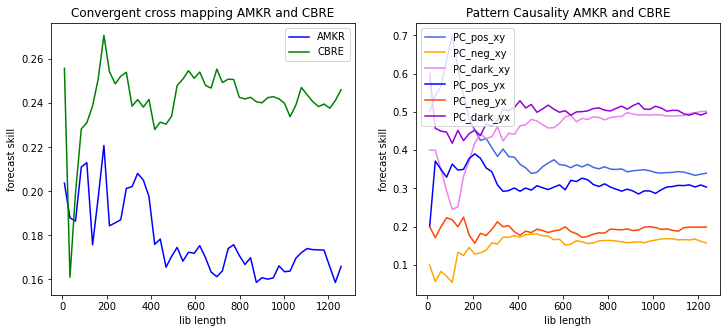

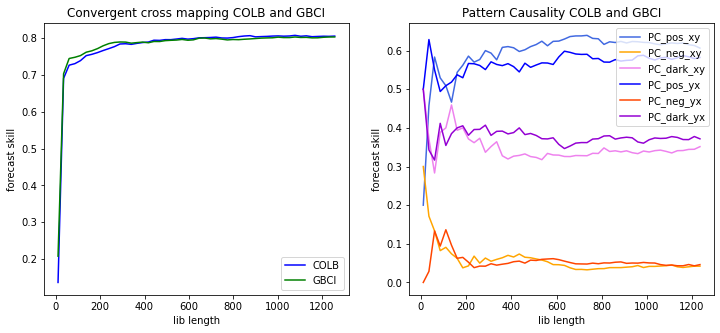

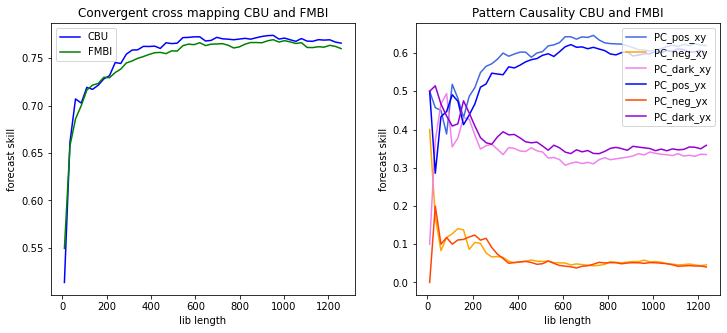

In [126]:
plot_ccm_pc(list1)

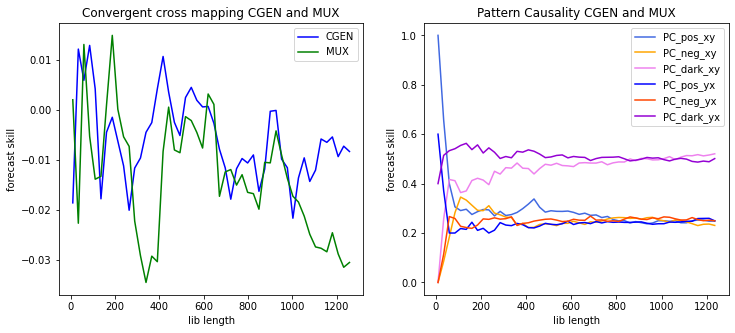

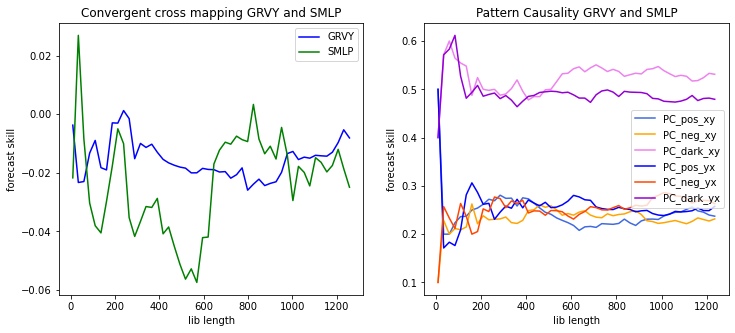

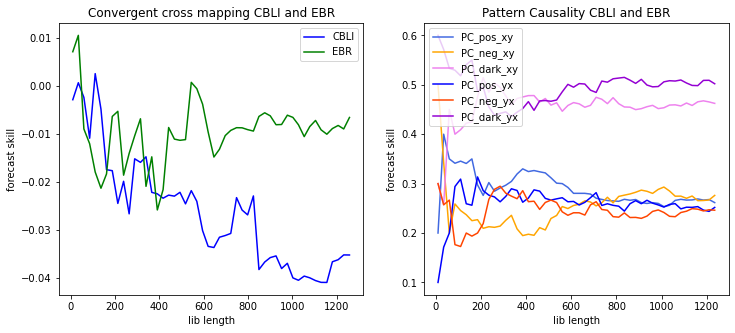

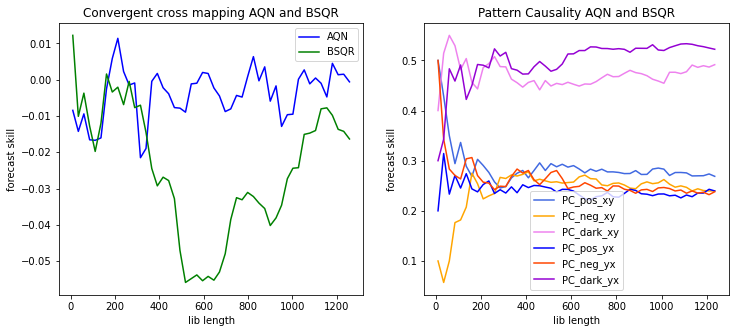

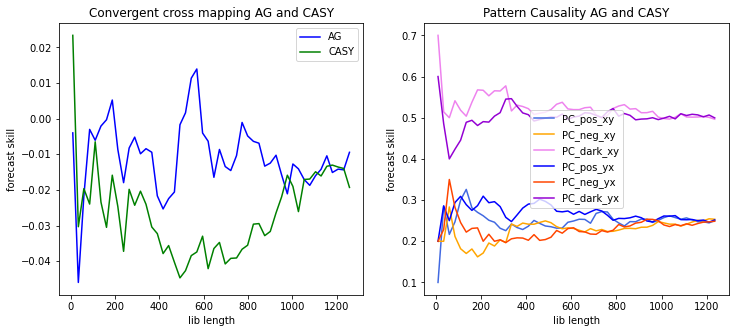

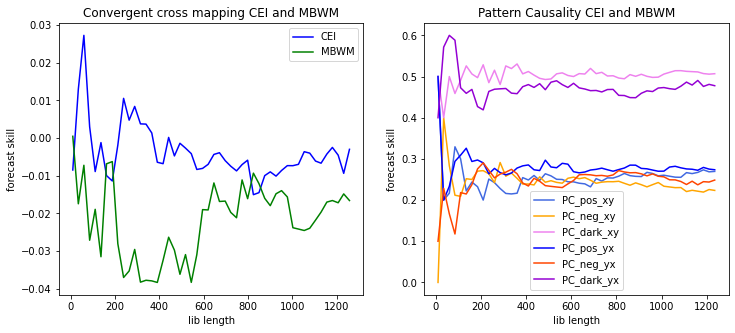

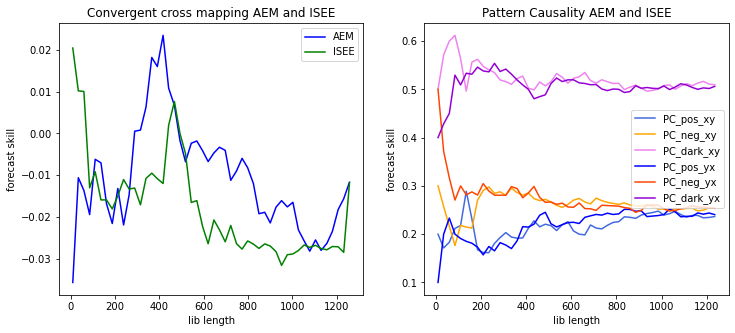

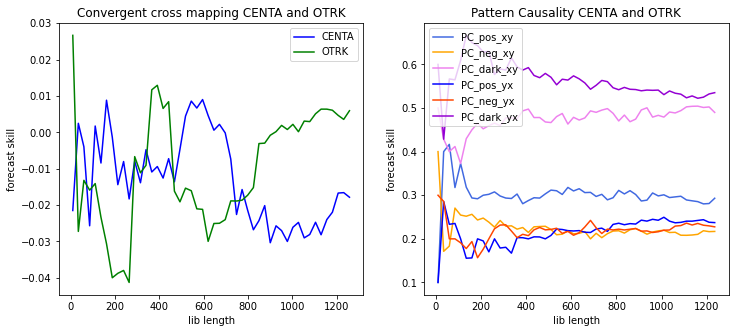

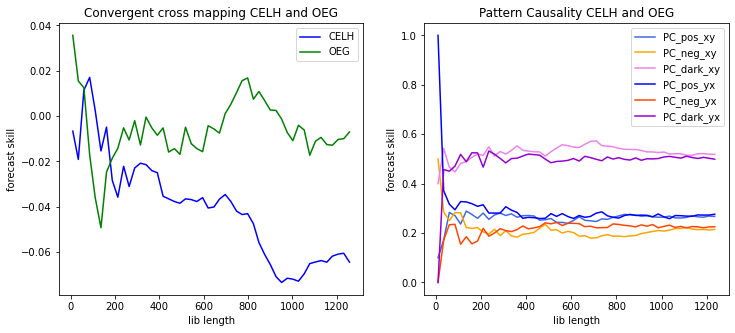

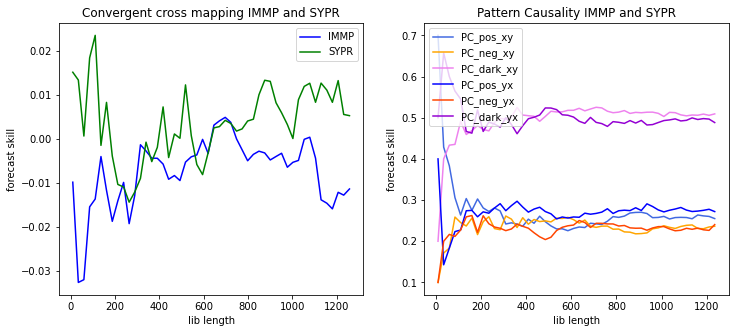

In [127]:
plot_ccm_pc(list2)

In [111]:
def exp_weight(X):
    norm = X[:,[0]] +.00001
    numer = np.exp(-X/norm)
    denom = np.sum(numer,axis=1,keepdims=True)
    W = numer/denom
    return W  

def corrcoef(preds, actual):
    cc = np.corrcoef(preds,actual)[0,1]
    return cc

@njit(parallel=True)
def numba_embed_vectors_1d(X, lag, embed):
        tsize = X.shape[0]
        t_iter = tsize-(lag*(embed-1))
        features = np.zeros((t_iter,embed))
        for ii in prange(t_iter):
            end_val = ii+lag*(embed-1)+1
            part = X[ii : end_val]
            features[ii,:] = part[::lag]
        return features
class C_C_M:

    def __init__(self, weights='exp', verbose=False):
        self.weights = weights
        self.verbose = verbose

    def fit(self,X1,X2):

        self.X1 = X1
        self.X2 = X2

        near_neighs = X1.shape[1] + 2

        self.knn1 = neighbors.KNeighborsRegressor(near_neighs) #, n_jobs=-1
        self.knn2 = neighbors.KNeighborsRegressor(near_neighs) #, n_jobs=-1

    def predict(self,lib_lengths):

        X1_pred = []
        X2_pred = []

        for liblen in lib_lengths:

            x1_p = np.empty(self.X1.shape)
            x2_p = np.empty(self.X2.shape)

            self.knn1.fit(self.X1[:liblen], self.X1[:liblen])
            self.knn2.fit(self.X2[:liblen], self.X2[:liblen])

            dist1,ind1 = self.knn1.kneighbors(self.X1)
            dist2,ind2 = self.knn2.kneighbors(self.X2)

            dist1 = dist1[:,1:]
            dist2 = dist2[:,1:]
            ind1 = ind1[:,1:]
            ind2 = ind2[:,1:]

            for j in range(self.X1.shape[1]):

                W1 = exp_weight(dist1)
                W2 = exp_weight(dist2)

                x1_p[:, j] = np.sum(self.X1[ind2, j] * W2, axis=1)
                x2_p[:, j] = np.sum(self.X2[ind1, j] * W1, axis=1)

            X1_pred.append(x1_p)
            X2_pred.append(x2_p)

        self.X1_pred = X1_pred
        self.X2_pred = X2_pred

        return X1_pred, X2_pred

    def ccm_score(self):

        num_preds = self.X1.shape[1]

        score_1 = []
        score_2 = []

        for x1_p, x2_p in zip(self.X1_pred, self.X2_pred):

            sc1 = np.empty(num_preds)
            sc2 = np.empty(num_preds)

            for ii in range(num_preds):

                p1 = x1_p[:,ii]
                p2 = x2_p[:,ii]

                sc1[ii] = corrcoef(p1,self.X1[:,ii])
                sc2[ii] = corrcoef(p2,self.X2[:,ii])

            score_1.append(np.mean(sc1))
            score_2.append(np.mean(sc2))

        return score_1, score_2

In [132]:
df3 = agg_df[(agg_df.coint_df_n==0) & (agg_df.coint_df_c==0) & (agg_df.coint_df_ct==0)].sort_values(by=['ccm_max_x', 'ccm_max_y', 'pc_max_x', 'pc_max_y'], ascending=[True, True, True, True])[:10]
df3

,ticker_x,ticker_y,coint_df_n,coint_df_c,coint_df_ct,gc_x,gc_y,ccm_max_x,ccm_max_y,ccm_mean_x,ccm_mean_y,pc_max_x,pc_max_y,pc_mean_x,pc_mean_y
173174,CGEN,MUX,0,0,0,0,0,-0.0,-0.0023,-0.0095,-0.0142,0.292,0.2506,0.2706,0.2315
322995,GRVY,SMLP,0,0,0,0,0,-0.0,-0.0046,-0.0127,-0.0289,0.264,0.272,0.2408,0.2495
156935,CBLI,EBR,0,0,0,0,0,-0.0,-0.0058,-0.0248,-0.01,0.336,0.268,0.28,0.2576
65563,AQN,BSQR,0,0,0,0,0,-0.0,-0.0081,-0.0063,-0.0243,0.296,0.272,0.2797,0.2439
510023,AG,CASY,0,0,0,0,0,-0.0,-0.0114,-0.0081,-0.0292,0.32,0.304,0.2596,0.2783
166004,CEI,MBWM,0,0,0,0,0,-0.0,-0.0166,-0.0035,-0.0262,0.2657,0.29,0.2518,0.2745
504109,AEM,ISEE,0,0,0,0,0,-0.0,0.0001,-0.0108,-0.0143,0.296,0.248,0.2291,0.2207
169307,CENTA,OTRK,0,0,0,0,1,-0.0,0.0059,-0.0132,-0.0144,0.344,0.242,0.3008,0.2071
166904,CELH,OEG,0,0,0,0,0,-0.0,0.0063,-0.0407,-0.0142,0.272,0.344,0.2626,0.2891
357246,IMMP,SYPR,0,0,0,0,0,-0.0,0.0083,-0.0081,0.0004,0.28,0.284,0.2596,0.2677
